У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [ ]:
!pip install darts

In [ ]:
!pip install prophet

In [135]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from darts import TimeSeries
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from darts.utils.statistics import check_seasonality, plot_hist, plot_residuals_analysis
from darts.models import NaiveSeasonal, NaiveDrift, XGBModel, ExponentialSmoothing, AutoARIMA, Prophet, RNNModel, ARIMA
from darts.metrics import mape, ae
from darts.dataprocessing.transformers import Scaler
%load_ext autoreload
%autoreload 2
from  scripts.timeseries import enrich_with_date_features
from prophet import Prophet
from darts.models import Prophet as Prophet2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df = pd.read_csv('data/timeseries/train.csv')
df.date=pd.to_datetime(df.date)
df.set_index('date', inplace=True)
df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [8]:
df.sort_index(ascending=False)

,store,item,sales
date,,,
2017-12-31,10,50,82
2017-12-31,8,28,87
2017-12-31,10,14,57
2017-12-31,7,6,39
2017-12-31,6,11,42
...,...,...,...
2013-01-01,9,34,19
2013-01-01,10,34,15
2013-01-01,1,35,28


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



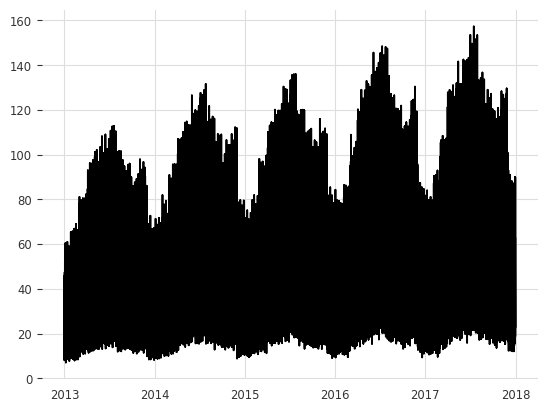

In [9]:
daily_item_mean_sales = df.groupby(['date', 'item'])['sales'].mean().reset_index()
daily_item_mean_sales.head()
plt.plot(daily_item_mean_sales.date, daily_item_mean_sales.sales)

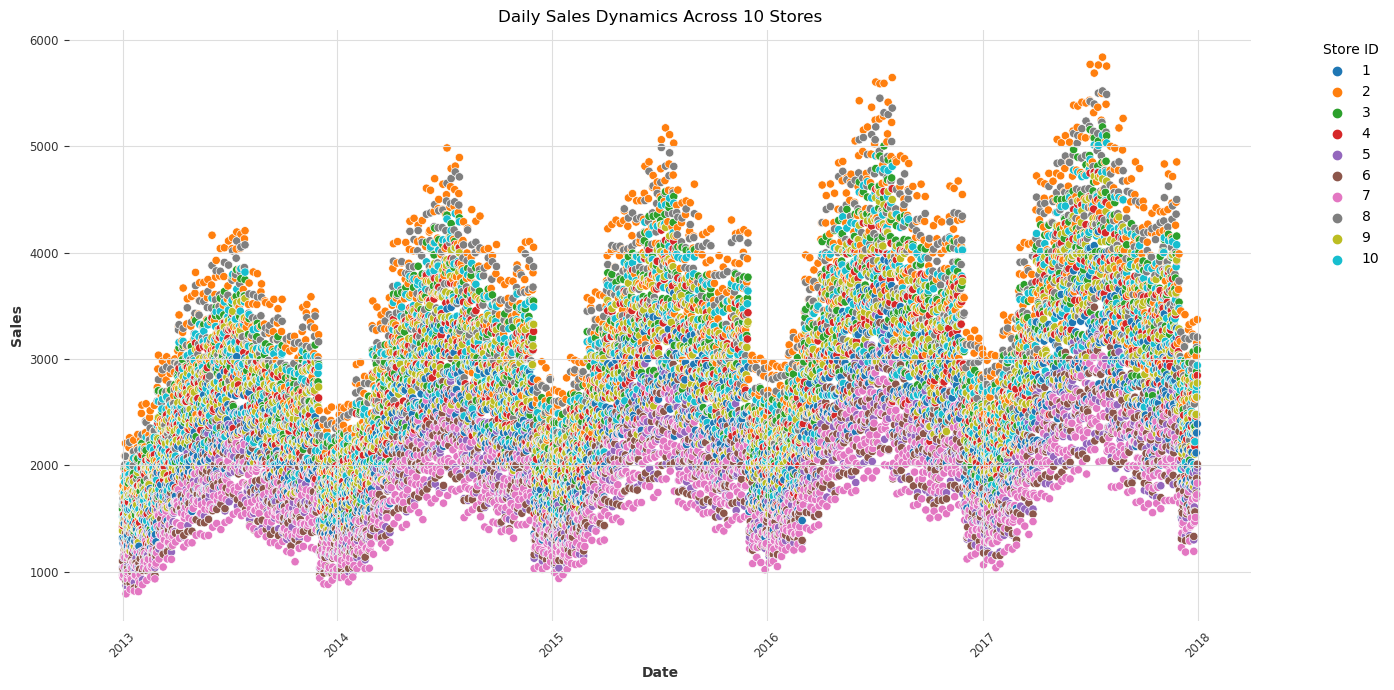

In [10]:
store_sales_daily = df.groupby(['date', 'store'])['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.scatterplot(data=store_sales_daily, x='date', y='sales', hue='store', palette='tab10')

# Налаштування графіка
plt.title('Daily Sales Dynamics Across 10 Stores')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Store ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [11]:
store_sales_daily.head()

,date,store,sales
0,2013-01-01,1,1316
1,2013-01-01,2,1742
2,2013-01-01,3,1588
3,2013-01-01,4,1423
4,2013-01-01,5,1032


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


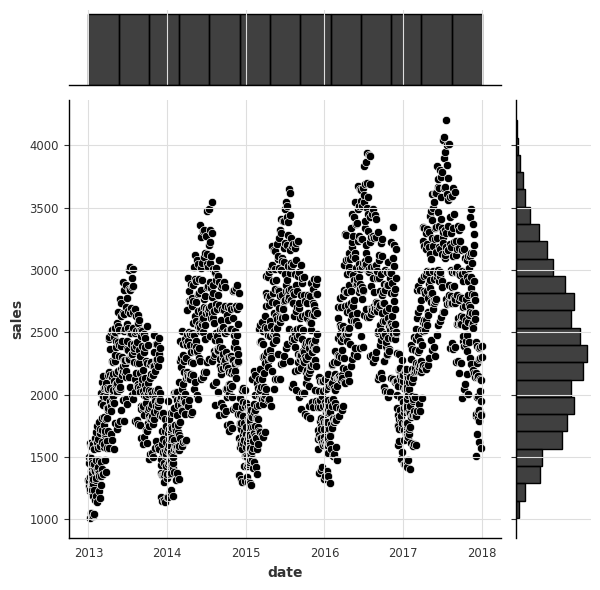

In [12]:
store_1_sales =store_sales_daily[store_sales_daily.store==1]
store_1_sales.head()
sns.jointplot(data = store_1_sales, x = store_1_sales['date'], y = store_1_sales['sales'])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date', ylabel='sales'>

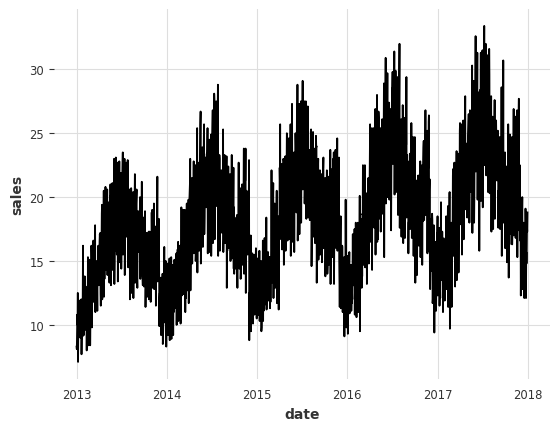

In [13]:
item_5_mean_sales = df[df.item==5].groupby('date')['sales'].mean().reset_index()
item_5_sales = df[df.item==5]
sns.lineplot(data=item_5_mean_sales, x = 'date', y = 'sales')
#plt.plot(item_5_sales)
#plt.show()

З графіків можна зробити висновок, що продажі як по айтемам так і по магазинах мають сезонну циклічність, досягаючи піку продажів всередині року і завжди мінімум продажів  - кінець року (сезонність - 12 місяців)
Також помітно, що розмах продажів збільшуєіься як і сама сума продаж (висхідний тренд)

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

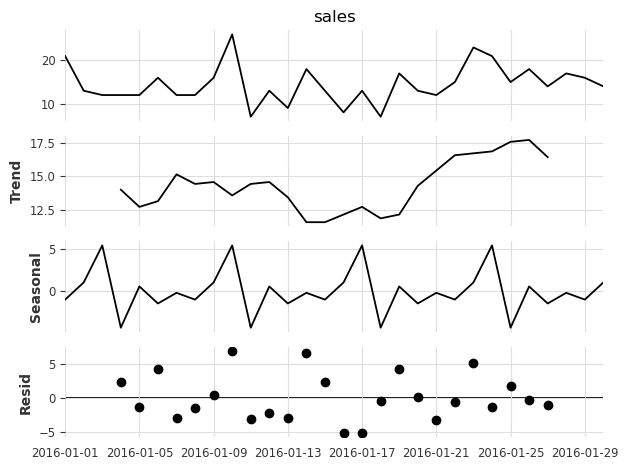

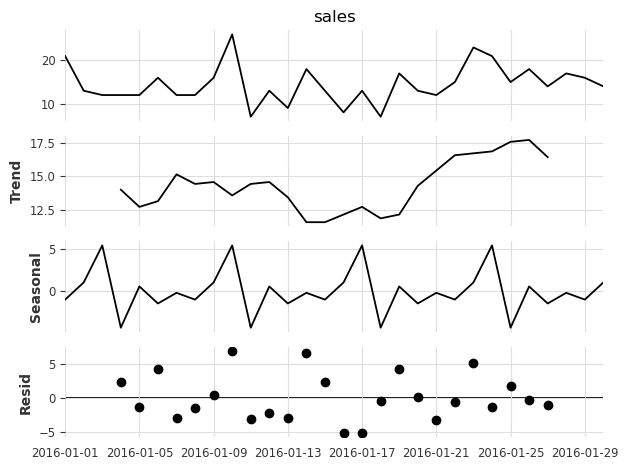

In [14]:
item_1_store_1 = df[(df.store==1) & (df.item==1)]
item_1_store_1_month = item_1_store_1.loc['2016-01-01':'2016-01-30']
decomp_1_1 = seasonal_decompose(item_1_store_1_month['sales'], model='additive')
decomp_1_1.plot()

Цікаво, що seasonal_decompose побачив сезонніcть в днях тижня, але на графіках явно видно ще й сезонність по місяцях року

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

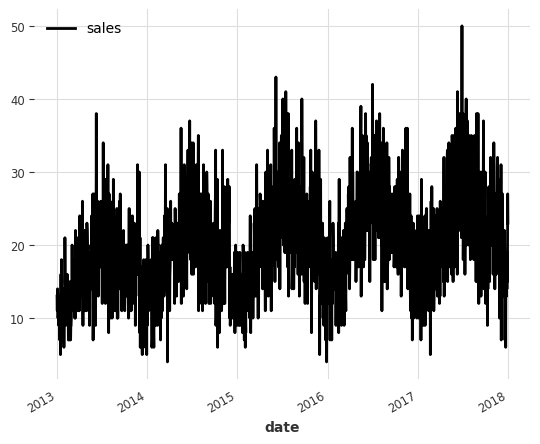

In [15]:
series = TimeSeries.from_dataframe(item_1_store_1, value_cols='sales')
series.plot()
plt.show()

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

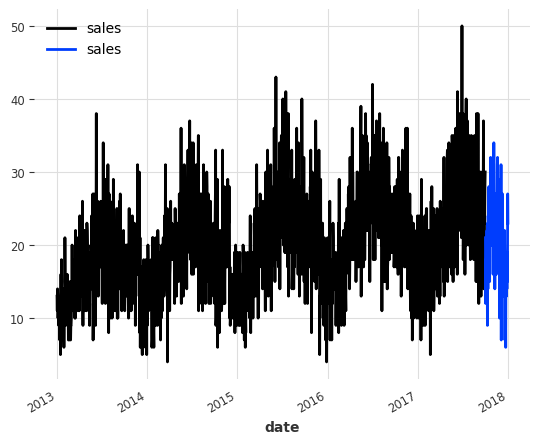

In [16]:
train_series, val_series = series.split_before(pd.Timestamp('2017-10-01'))
train_series.plot()
val_series.plot()
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [17]:
df.sales.head()

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
Name: sales, dtype: int64

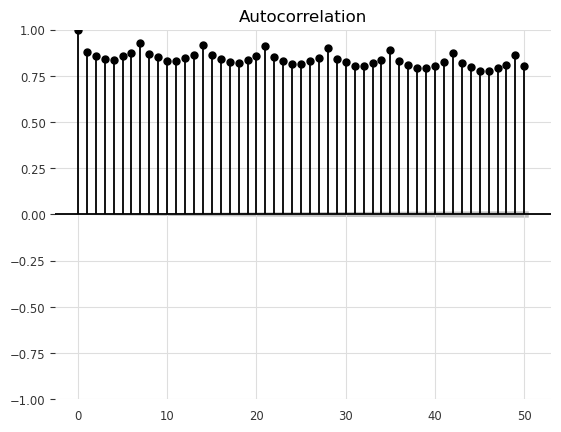

In [18]:
plot_acf(df.sales, lags=50)
plt.show()

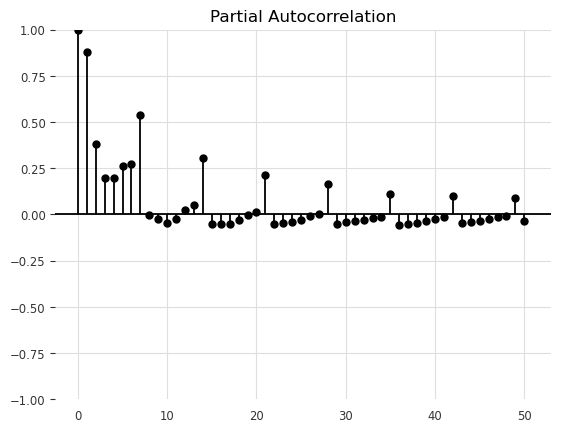

In [19]:
plot_pacf(df.sales, lags=50)
plt.show()

plot_acf і plot_pacf показують сезонність 7 (днів)

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [20]:
print(check_seasonality(train_series))
print(check_seasonality(train_series, 7))
print(check_seasonality(train_series, 12))
print(check_seasonality(train_series, 30, max_lag=31))

(True, 7)
(True, 7)
(False, 12)
(False, 30)


Моє припущення про сезоннсіть 12 не підтверджується функцією

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

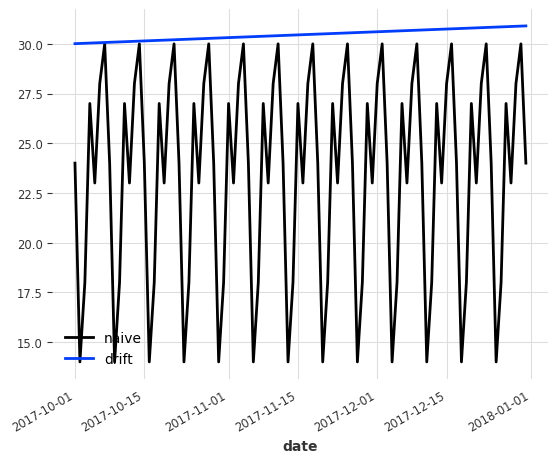

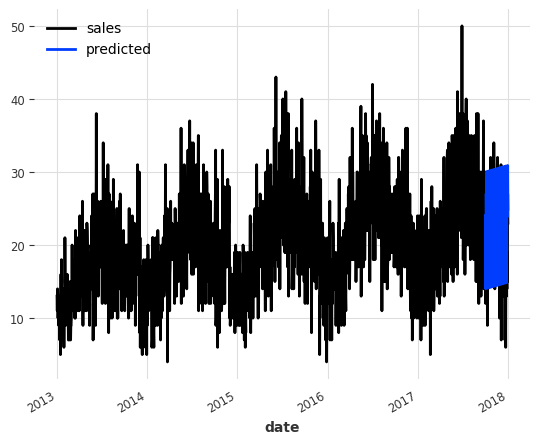

In [21]:
naive_seasonal = NaiveSeasonal(K=7)
naive_seasonal.fit(train_series)
naiveforecast = naive_seasonal.predict(val_series.time_index.size)
drift_model = NaiveDrift()
drift_model.fit(train_series)
drift_forecast = drift_model.predict(val_series.time_index.size)
forecast = naiveforecast + drift_forecast - train_series.last_value()
naiveforecast.plot(label="naive")
drift_forecast.plot(label="drift")
series.plot("original")
forecast.plot(label="predicted")
plt.show()


Тут все ж є явна річна сезонність
Тому варто враховувати їх обидві

<Axes: xlabel='date'>

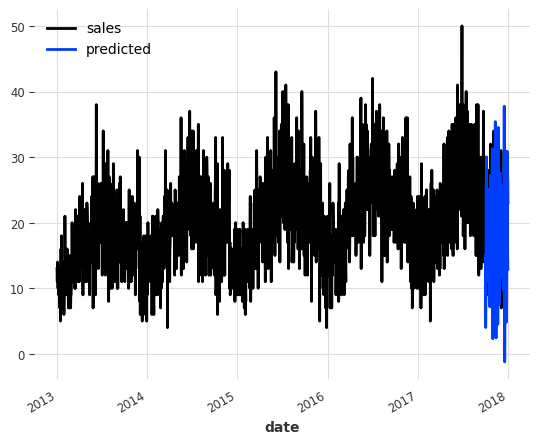

In [22]:
naive_year_seasonal_train = series.slice(pd.Timestamp('2016-01-01'), pd.Timestamp('2016-12-31'))
naive_seasonal_12 = NaiveSeasonal(K=12)
naive_seasonal_12.fit(train_series)
naiveforecast_12 = naive_seasonal_12.predict(val_series.time_index.size)
forecast_7_12 = naiveforecast_12 + naiveforecast + drift_forecast - 2*train_series.last_value()
series.plot("original")
forecast_7_12.plot(label="predicted")

Як на мене результат покращився

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [23]:
mape_ = mape(val_series, forecast)
mape_7_12 = mape(val_series, forecast_7_12)

print(f" MAPE: {mape_:.2f}%")
print(f" MAPE 2 seasons : {mape_7_12:.2f}%")

 MAPE: 39.91%
 MAPE 2 seasons : 41.95%


По метриках друга модель гірша, але вони обидві дають велчезну помилку

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [24]:
params = {
    'hour': False,
    'dayofweek': True,
    'quarter': True,
    'month': True,
    'year': True,
    'dayofyear': True,
    'sin_day': True,
    'cos_day': True,
    'dayofmonth': True
}

enriched_train= enrich_with_date_features(train_series.pd_dataframe().reset_index(), params, 'date')
enriched_val= enrich_with_date_features(val_series.pd_dataframe().reset_index(), params, 'date')

enriched_train.date
enriched_train.set_index('date', inplace=True)
enriched_train_series = TimeSeries.from_dataframe(enriched_train)
enriched_val.set_index('date', inplace=True)
enriched_val_series = TimeSeries.from_dataframe(enriched_val)

scaler = Scaler()
enriched_train_series = scaler.fit_transform(enriched_train_series)
enriched_val_series = scaler.transform(enriched_val_series)

In [25]:
xgb = XGBModel(
    lags=30, 
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=5,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8 
)
xgb.fit(enriched_train_series)
xgb_pred_scaled = xgb.predict(len(val_series))
xgb_pred = scaler.inverse_transform(xgb_pred_scaled)


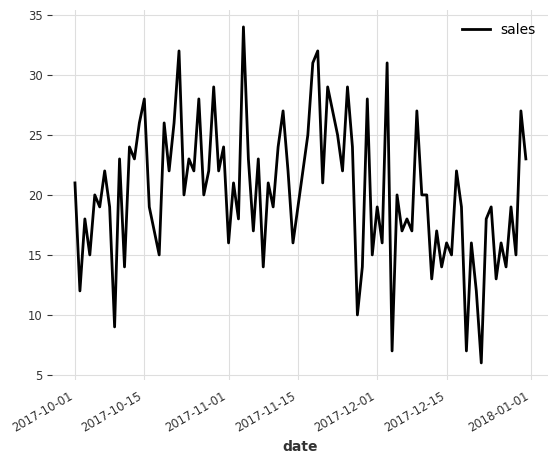

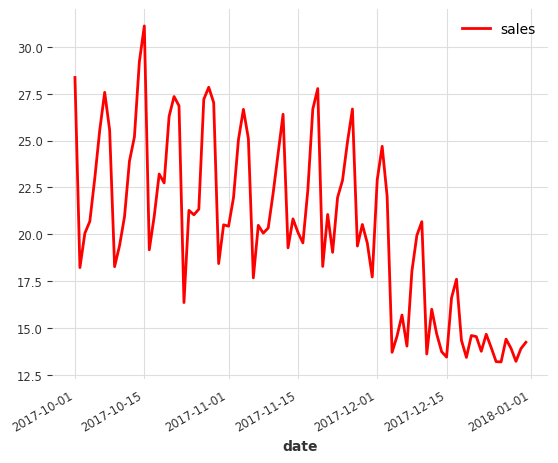

In [26]:
val_series.plot("Actual")
xgb_pred['sales'].plot("Predicted", color="red")
plt.legend()
plt.show()

In [27]:
mape_xgb = mape(val_series, xgb_pred['sales'])
print("xgBoost mape={}".format(mape_xgb.round(2)))

xgBoost mape=23.82


Не зрозуміло, чому графіки не хочуть малюватися на одному полотні
Бачимо, що точність стала кращою і графік прогнозу візуально нагадує дійсні значення, хоча помилка маре все ще велика

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

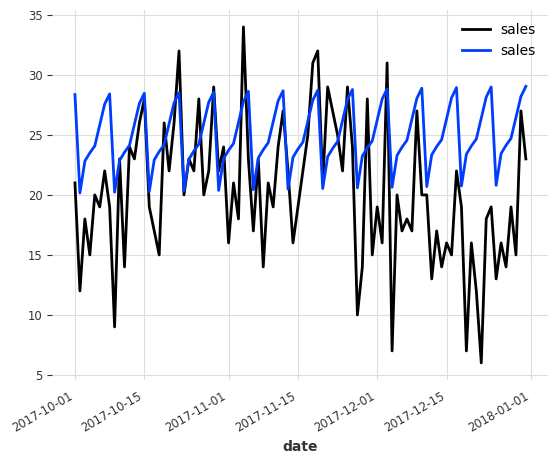

In [28]:
expon_model = ExponentialSmoothing(seasonal_periods=7)
expon_model.fit(train_series)
expon_pred = expon_model.predict(len(val_series))
val_series.plot()
expon_pred.plot()
plt.show()

In [29]:
mape_expon = mape(val_series, expon_pred)
print("Exponential smoothing  mape={}".format(mape_expon.round(2)))

Exponential smoothing  mape=38.94


На жаль результат ще гірший? можливо потрібно затюнити парметри моделі

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [30]:
add_encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'future': ['relative']},
    'transformer': Scaler(),
    'tz': 'CET'
}
#З використання add_encoders модель не зійшлася
arima_model = ARIMA(
    p = 5, d = 1, q=1, seasonal_order = (1, 1, 1, 7), random_state=12
)
arima_model.fit(train_series)
arima_pred = arima_model.predict(len(val_series))

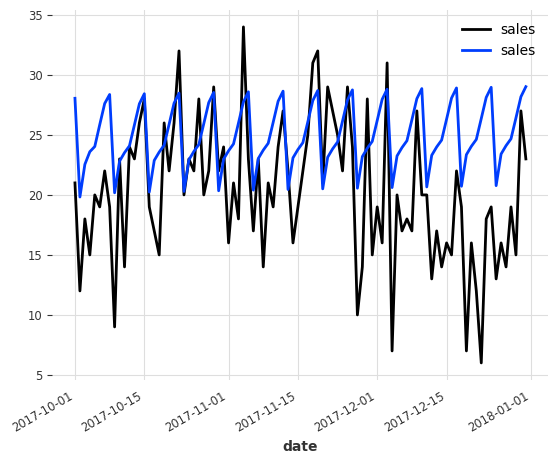

In [31]:
val_series.plot()
arima_pred.plot()
plt.show()

In [32]:
mape_arima = mape(val_series, arima_pred)
print("Arima  mape={}".format(mape_arima.round(2)))

Arima  mape=38.76


ARIMA спочатку спрогнозувала досить непогано, але потім щось пішло не так))


13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [33]:
auto_arima_model = AutoARIMA(start_p=5, max_p=12, start_q=1)
auto_arima_model.fit(train_series)
auto_arima_pred = auto_arima_model.predict(len(val_series))

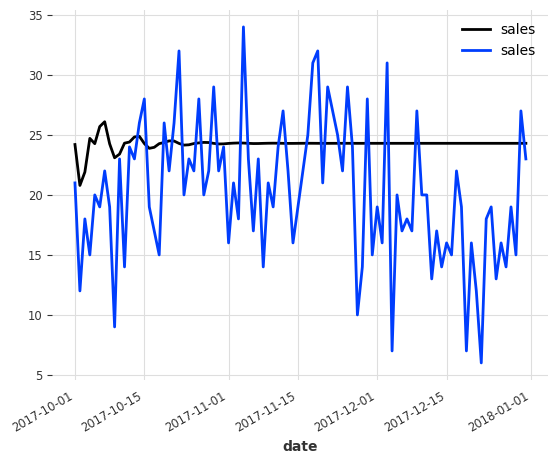

In [34]:
auto_arima_pred.plot()
val_series.plot()
plt.show()

In [35]:
mape_autoarima = mape(val_series, auto_arima_pred)
print("Auto Arima  mape={}".format(mape_autoarima.round(2)))

Auto Arima  mape=39.53


In [36]:
auto_arima_model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Sat, 17 Aug 2024   AIC                          10591.078
Time:                        21:25:55   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.905      0.365      -0.040       0.109
ar.L2         -0.0798      0.034     -2.376      0.018      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.317      0.020      -0.143      -0.012
ar.L4         -0.0650      0.034     -1.936      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.064      0.287      -0.097       0.029
ar.L6          0.0063      0.030      0.209      0.834      -0.053       0.065
ar.L7          0.2638      0.029      9.044      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.258      0.000      -0.959      -0.855
sigma2        26.0958      0.820     31.811      0.000      24.488      27.704
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Аріма з моїми ручними настройками відпрацювала з меншою помилкою

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [51]:
train_df_prophet = train_series.pd_dataframe().reset_index()
train_df_prophet['ds'] = train_df_prophet['date']
train_df_prophet['y'] = train_df_prophet['sales']
train_df_prophet = train_df_prophet[['ds','y']]

In [55]:
val_df_prophet = val_series.pd_dataframe().reset_index()
val_df_prophet['ds'] = val_df_prophet['date']
val_df_prophet['y'] = val_df_prophet['sales']
val_df_prophet = val_df_prophet[['ds','y']]

In [67]:
prophet_model = Prophet()
prophet_model.fit(train_df_prophet)
prophet_pred = prophet_model.predict(val_df_prophet)
prophet_pred

21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-10-01,22.922228,21.019880,32.412226,22.922228,22.922228,3.715027,3.715027,3.715027,3.765114,3.765114,3.765114,-0.050087,-0.050087,-0.050087,0.0,0.0,0.0,26.637255
1,2017-10-02,22.925076,12.550389,23.844207,22.925076,22.925076,-4.443913,-4.443913,-4.443913,-4.420154,-4.420154,-4.420154,-0.023758,-0.023758,-0.023758,0.0,0.0,0.0,18.481163
2,2017-10-03,22.927925,15.254608,26.792780,22.927925,22.927925,-1.794455,-1.794455,-1.794455,-1.798091,-1.798091,-1.798091,0.003636,0.003636,0.003636,0.0,0.0,0.0,21.133469
3,2017-10-04,22.930773,15.752549,27.663048,22.930773,22.930773,-1.082020,-1.082020,-1.082020,-1.111777,-1.111777,-1.111777,0.029757,0.029757,0.029757,0.0,0.0,0.0,21.848753
4,2017-10-05,22.933621,16.827433,27.911226,22.933621,22.933621,-0.498108,-0.498108,-0.498108,-0.550449,-0.550449,-0.550449,0.052341,0.052341,0.052341,0.0,0.0,0.0,22.435514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2017-12-27,23.170040,10.687306,22.341303,23.159829,23.178649,-6.710138,-6.710138,-6.710138,-1.111777,-1.111777,-1.111777,-5.598361,-5.598361,-5.598361,0.0,0.0,0.0,16.459902
88,2017-12-28,23.172889,11.953749,22.506738,23.162388,23.181824,-6.058745,-6.058745,-6.058745,-0.550449,-0.550449,-0.550449,-5.508296,-5.508296,-5.508296,0.0,0.0,0.0,17.114143
89,2017-12-29,23.175737,13.499785,24.477544,23.165152,23.184985,-4.247248,-4.247248,-4.247248,1.184267,1.184267,1.184267,-5.431515,-5.431515,-5.431515,0.0,0.0,0.0,18.928489
90,2017-12-30,23.178585,14.964345,26.409194,23.167814,23.188027,-2.438640,-2.438640,-2.438640,2.931090,2.931090,2.931090,-5.369730,-5.369730,-5.369730,0.0,0.0,0.0,20.739945


In [72]:
prophet_pred['yhat']

0     26.637255
1     18.481163
2     21.133469
3     21.848753
4     22.435514
        ...    
87    16.459902
88    17.114143
89    18.928489
90    20.739945
91    21.622468
Name: yhat, Length: 92, dtype: float64

In [76]:
prophet_pred_df = prophet_pred[['ds','yhat']].set_index('ds')
prophet_pred2 = TimeSeries.from_dataframe(prophet_pred_df)


Prophet MAPE: 23.81


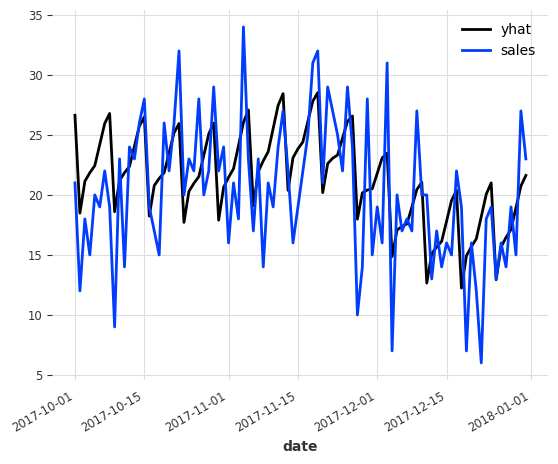

In [79]:

# Обчислення MAPE
prophet_mape = mape(val_series, prophet_pred2)

print("Prophet MAPE: {:.2f}".format(prophet_mape))
prophet_pred2.plot()
val_series.plot()
plt.show()

Поки що це найкращий результат і графік це підтверджує

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [85]:
rnn_model = RNNModel(input_chunk_length = 7, model = 'LSTM', n_epochs=300)
rnn_model.fit(train_series)
rnn_predict = rnn_model.predict(len(val_series))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

На жаль? не змогла запустити локально

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [88]:
df.index.min()

Timestamp('2013-01-01 00:00:00')

In [93]:
prophet2 = Prophet2()
prophet2.fit(train_series)
prophet2_pred = prophet2.predict(len(val_series))
mape_prophet2 = mape(val_series, prophet2_pred)
print("MAPE Prophet Darts {}".format(mape_prophet2))

00:17:16 - cmdstanpy - INFO - Chain [1] start processing
00:17:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE Prophet Darts 23.806411778894216


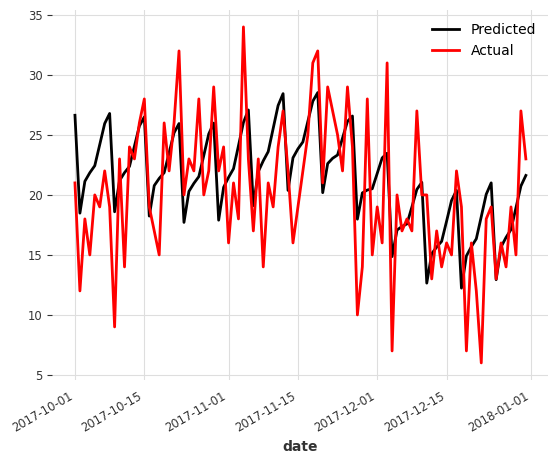

In [102]:
prophet2_pred.plot(label = "Predicted")
val_series.plot(color = "red", label="Actual")
plt.show()

Ура! Підгрузився профет з дартс і я змогла натренувати модельку і результат виявився найкращим)

In [99]:
hfc_params = {
    'series': series,
    'start': pd.Timestamp('2014-01-01'),
    'forecast_horizon': 3,
    'verbose': True
}


In [100]:

prophet_model.historical_forecasts(last_points_only = True, **hfc_params)

AttributeError: 'Prophet' object has no attribute 'historical_forecasts'

У звичайного prophet немає історичного форкасту, пробую тепер дартс - 

залишаю тут код і помилку як нагадування того, що prophet може бути і не дартс

In [ ]:
darts_prophet_historical = prophet2.historical_forecasts(last_points_only = True, **hfc_params)

<Axes: xlabel='time'>

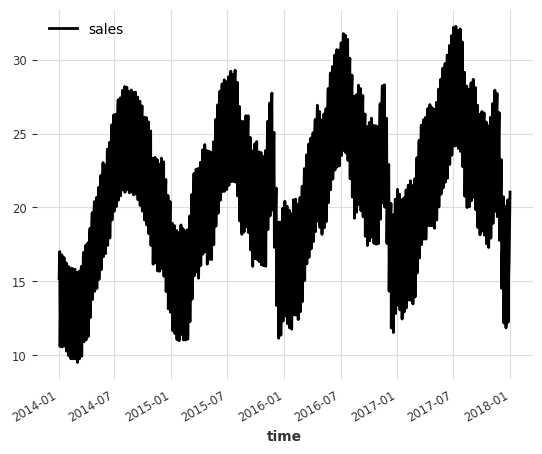

In [104]:
darts_prophet_historical.plot()

Всю варіантивність не вгадали, але виглядає непогано!

Дуже схоже на реальну картину продажів

In [ ]:
darts_prophet_historical_precomp = prophet2.historical_forecasts(
    last_points_only = False, 
    stride = 1,
    **hfc_params)

In [119]:
error_precomp = prophet2.backtest(
    historical_forecasts=darts_prophet_historical_precomp, 
    last_points_only=False,
    stride = 1,
    **hfc_params)

In [ ]:
average_error = prophet2.backtest(
    metric = mape, 
    reduction=np.mean,
    **hfc_params
)

In [120]:
error_precomp

21.982289200809433

In [118]:
average_error

21.982289200809433

In [ ]:
raw_errors = prophet2.backtest(
    stride=1, last_points_only=False,metric=mape,**hfc_params, reduction=None
)

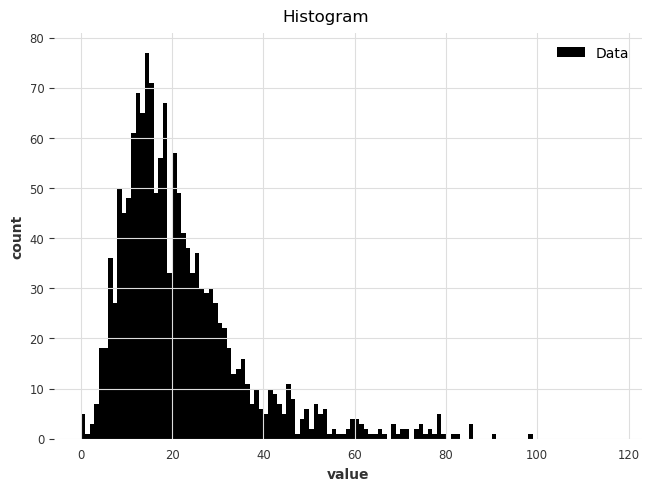

In [126]:
plot_hist(raw_errors, bins = np.arange(0, max(raw_errors), 1))

Бачимо тут лівоскошений нормальний розподіл

In [ ]:
residuals = prophet2.residuals(series=series)

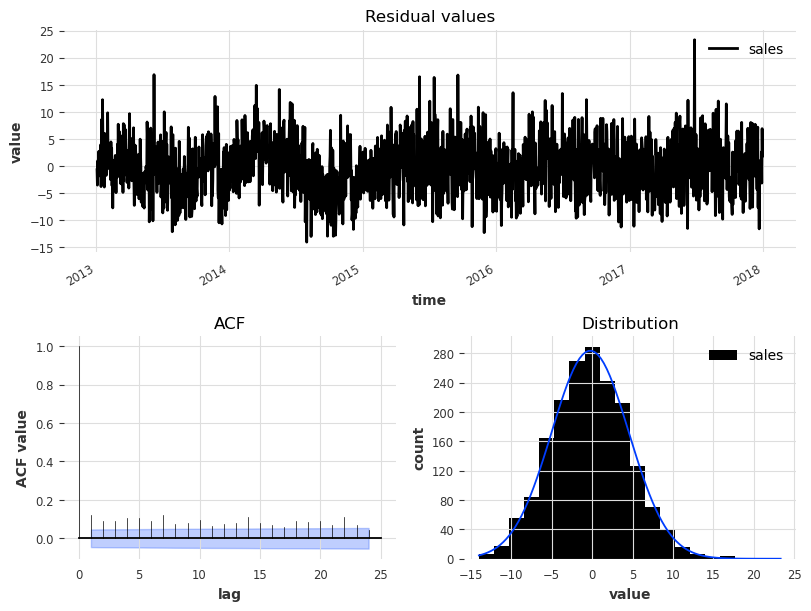

In [129]:
plot_residuals_analysis(residuals=residuals)

Distibution навколо 0 - це добре, але на графіку ACF бачимо багато точок поза довірчим інтервалом, а отже вони корелюють і можна же вибілити паттерн

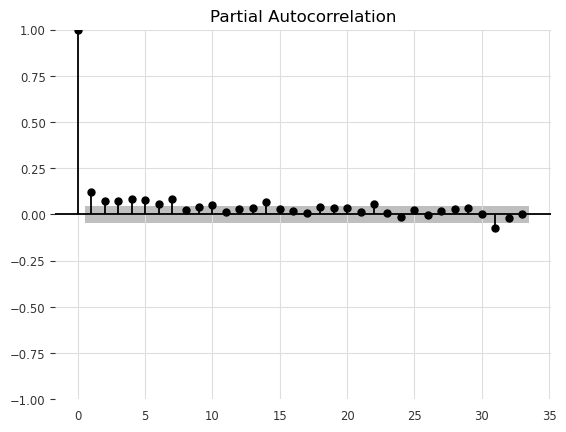

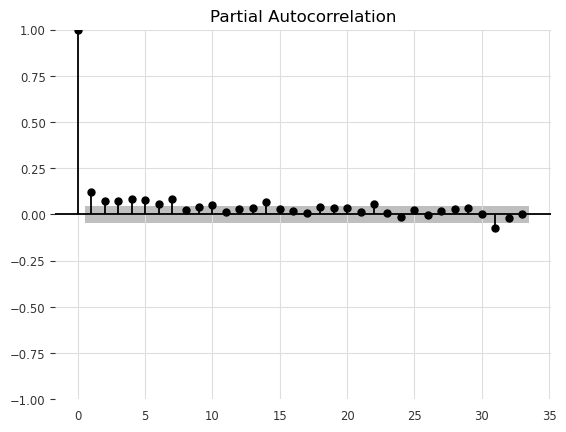

In [133]:
plot_pacf(residuals.pd_dataframe())

Прогляжається сезонність в залишках - тижнева, місячна

In [ ]:
residuals_ae = prophet2.residuals(
    metric = ae,
    last_points_only=False,
    stride=1, 
    values_only=True,
    **hfc_params
)

Text(0.5, 1.0, 'Absolute errors per forecast step')

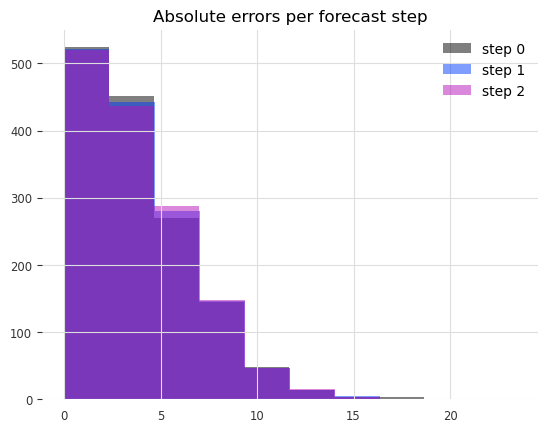

In [150]:
residuals_ae = np.concatenate(residuals_ae, axis=1)[:, :, 0]

fig, ax = plt.subplots()
for forecast_step in range(len(residuals_ae)):
    ax.hist(residuals_ae[forecast_step], label=f"step {forecast_step}", alpha=0.5)
ax.legend()
ax.set_title("Absolute errors per forecast step")

Цікаво, що немає сильної похибки на другий та третій день, тоді як опція ще можна убло б предіктити на більше днів вперед і побачити на якому ж дні помилка збільшується

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Скажу чесно - запитила у chatGPT) мені імпонує варіант групування товарів і магазинів за динамікою і прогнозування вже для цих агрегованих сутностей